## A machine learning approach to determine chemical shifts in NMR spectroscopy data

Maxime Epars, Gianni Giusto, Yann Mentha

_Code available on the [GitHub](https://github.com/ymentha14/MLprojectfall2019/tree/master/project2) repository._

_____


Note: all the cells can be runned if you set the parameter `run_this_cell` to `True`. To avoid computationally demanding executions, we pre-runned all presented results and saved them in `pickle` files.

## Table of content
1. [Exploratory data analysis](#eda) <br>
    1.1 [Import and load data](#import_data) <br>
    1.2 [Feature distributions](#features_distributions) <br>

2. [Feature processing and engineering](#feature_processing) <br>
    2.1 [Outliers removal](#outliers_removal) <br>
    2.2 [PCA](#pca) <br>
    2.3 [Feature selection](#feature_selection) <br>

3. [Linear models](#linear_models) <br>
    3.1 [Pipeline 1: ridge](#pipeline_1) <br>
    3.2 [Pipeline 2: random forest](#pipeline_2) <br>

4. [Neural networks](#neural_nets) <br>
    4.1 [Architecture](#nn_architecture) <br>
    4.2 [Training and cross-validation](#nn_training) <br>
    4.3 [Performance evaluation](#nn_perf_eval) <br>

5. [Ensemble methods](#ensemble_method) <br>
    5.1 [Training](#em_training) <br>
    5.2 [Performance avaluation](#em_perf_eval) <br>

_____

In [12]:
import os
import scipy.stats
import sklearn.metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import pickle

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# For neural net part
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

In [20]:
%load_ext autoreload
#%reload_ext autoreload
%autoreload 2

import helpers as hl
import data_viz as dv
import outliers
import neural_nets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Exploratory data analysis
<a id='eda'></a>

3 data files corresponding to a cutting radius of 3, 5 and 7$\overset{\circ}{A}$.

In [72]:
data_folder = './data'

files = os.listdir(data_folder)  
X_files = [filename for filename in files if (filename.endswith('.npy') and ('rsr' in filename))]
y_files = [filename for filename in files if (filename.endswith('.npy') and ('chemical_shielding' in filename))]

X_tot = np.load(data_folder + '/' + X_files[1], mmap_mode='r')
y_tot = np.load(data_folder + '/' + y_files[0], mmap_mode='r')

In [4]:
print('The dataset contains {} samples and {} features.'.format(X_tot.shape[0], X_tot.shape[1]))

The dataset contains 38514 samples and 14400 features.


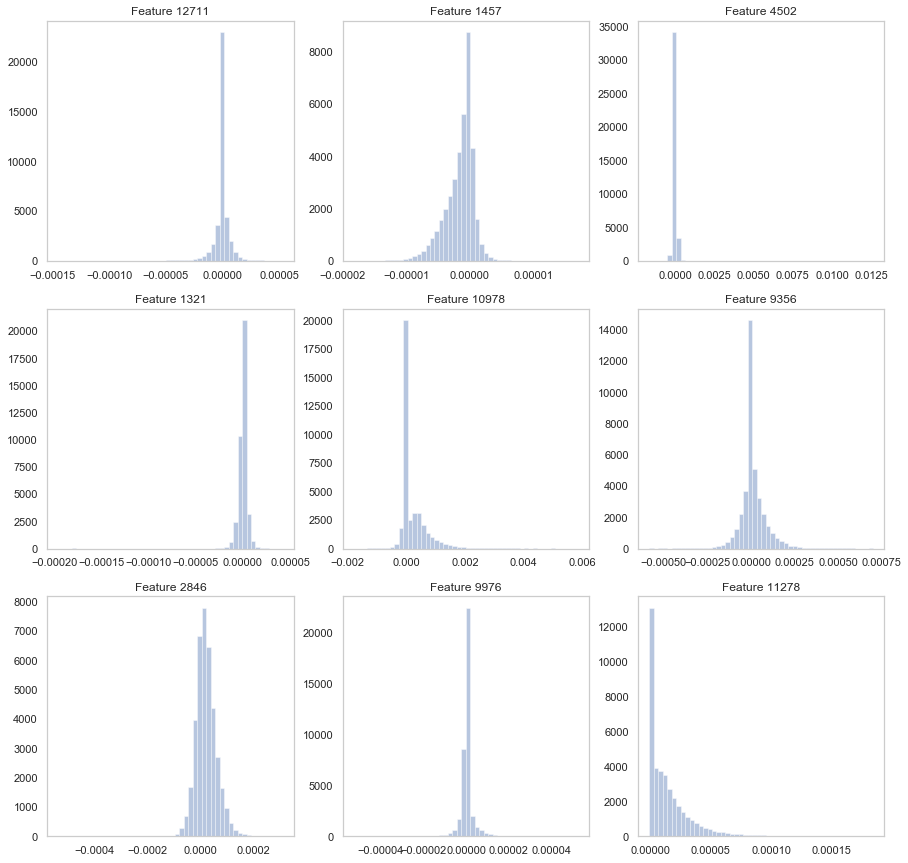

In [87]:
dv.plot_feature_dist(X_tot)

<div class="alert alert-block alert-success">
We display here some <b>features distribution</b> to get an insight of their distribution. The data is obviously not normally distributed for all the features.
</div>

## 2. Feature processing and engineering
<a id='feature_processing'></a>

#### 2.1 Outliers removal
<a id='outliers_removal'></a>

In [8]:
X_filtered, y_filtered = hl.remove_outliers(X_tot, y_tot)

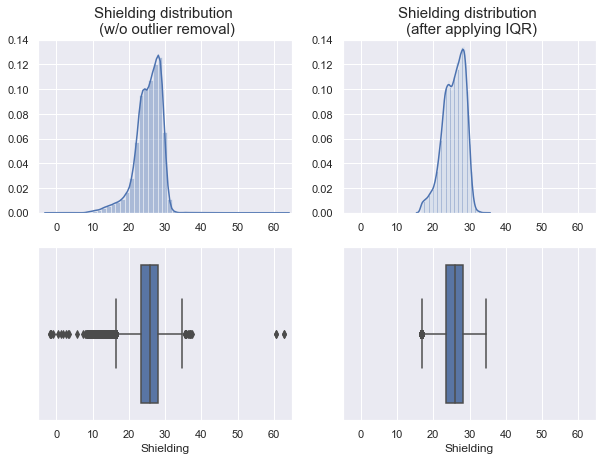

In [75]:
dv.plot_iqr(y_tot, y_filtered)

In [10]:
print('There are {} outliers.'.format(y_tot.shape[0] - y_filtered.shape[0]))

There are 1176 outliers.


<div class="alert alert-block alert-success">
Illustration of the <b>IQR</b> method when removing outliers on the shielding labels. Despite the realtive low number of outliers compared to the actual size of the dataset, we hypothesised that they may influence the model performance. To illustrate this, we select n samples from the total raw data and build a model with and without outliers in the training set. We repeat the process 4 times for statistical purposes. 
</div>

In [93]:
run_this_cell = False

if run_this_cell:
    noiqr_5000_mse, noiqr_20000_mse, iqr_5000_mse, iqr_20000_mse, noiqr_5000_mae, noiqr_20000_mae, iqr_5000_mae, iqr_20000_mae, noiqr_5000_r2, noiqr_20000_r2, iqr_5000_r2, iqr_20000_r2 = compute_iqr_effect(5000, 20000, n_fold, X_tot, y_tot, apply_pca=False)
with open('stats_iqr_vs_n_nopca_modifiedloaddata.pkl', 'rb') as f: 
    noiqr_5000_mse, noiqr_20000_mse, iqr_5000_mse, iqr_20000_mse, noiqr_5000_mae, noiqr_20000_mae, iqr_5000_mae, iqr_20000_mae, noiqr_5000_r2, noiqr_20000_r2, iqr_5000_r2, iqr_20000_r2 = pickle.load(f)


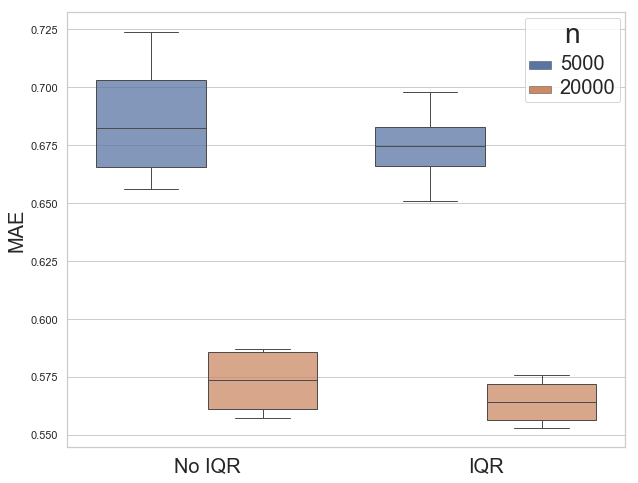

In [101]:
dv.plot_iqr_effect(noiqr_5000_mae, noiqr_20000_mae, iqr_5000_mae, iqr_20000_mae)

<div class="alert alert-block alert-success">
<b></b> 
For statistical relevance, we perform a 4-fold cross-validation on 2 different samples sizes data including a neighborhood of 5 Angstrom. Increasing the sample size naturally lead to a deacrase of the error (here the MAE). Results obtained with the IQR method display less variance than the ones acquired without the help of this method.
</div>

#### 2.2 PCA
<a id='pca'></a>

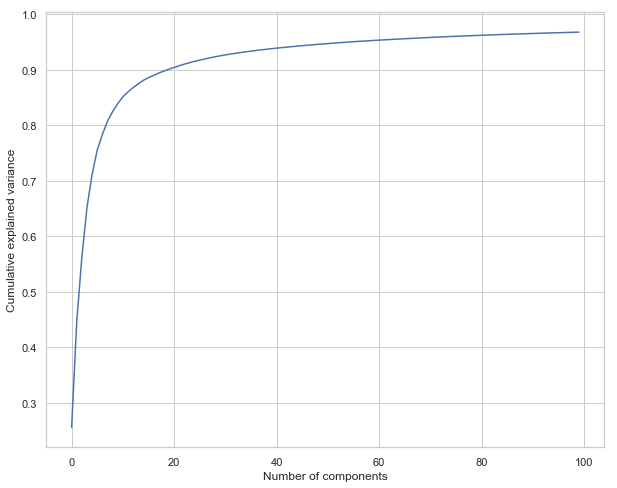

In [23]:
dv.plot_PCA(100, X_filtered)

<div class="alert alert-block alert-success">
When using <b>PCA</b>, we selected a number of components equal to the $98\%$ of the total explained variance, <i>i.e.</i> 80 principle components.
</div>

#### 2.4 Feature selection
<a id='feature_selection'></a>

## 3. Linear models
<a id='linear_models'></a>

#### 3.1 Pipeline 1 - Ridge
<a id='pipeline_1'></a>

In [ ]:
# Import obtained data
with open('xxx.pkl', 'rb') as f: 
    x1, x2, x3  = pickle.load(f)


#### 3.2 Pipeline 2 - Random forest
<a id='pipeline_2'></a>

## 4. Neural networks
<a id='neural_nets'></a>

#### 4.1 Architecture
<a id='nn_architecture'></a>

In [24]:
class Net_3(nn.Module):
    def __init__(self, n):
        super(Net_3, self).__init__()
        self.fc1 = nn.Linear(n,100)
        self.fc2 = nn.Linear(100,1)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

#### 4.2 Training and cross-validation
<a id='nn_training'></a>

In [91]:
run_this_cell = False

if run_this_cells:
    n = 10000
    mse_4fold, mae_4fold, r2_4fold = neural_nets.k_fold_nn(n, X_tot, y_tot, iqr=True)
else:
    with open('metrics_all_dataset2_net4_4fold_modifiedloaddata.pkl', 'rb') as f: 
        mse_4fold, mae_4fold, r2_4fold = pickle.load(f)

#### 4.3 Performance evaluation
<a id='nn_perf_eval'></a>

In [92]:
tab = [ ["", 'MSE', 'MAE', 'r2'],
        ["Net_3", '{:0.2f} +/- {:0.4f}'.format(np.mean(mse_4fold), np.std(mse_4fold)), 
                  '{:0.2f} +/- {:0.4f}'.format(np.mean(mae_4fold), np.std(mae_4fold)), 
                  '{:0.2f} +/- {:0.4f}'.format(np.mean(r2_4fold), np.std(r2_4fold))]]
print(tabulate(tab, tablefmt='fancy_grid'))

╒═══════╤═════════════════╤═════════════════╤═════════════════╕
│       │ MSE             │ MAE             │ r2              │
├───────┼─────────────────┼─────────────────┼─────────────────┤
│ Net_3 │ 0.66 +/- 0.0846 │ 0.53 +/- 0.0057 │ 0.95 +/- 0.0056 │
╘═══════╧═════════════════╧═════════════════╧═════════════════╛


<div class="alert alert-block alert-success">
The latter results were obtained using a 4-fold cross-validation on the entire dataset including a neighborhood of 5 Angstrom.
</div>

## 5. Ensemble methods
<a id='ensemble_methods'></a>

> Blablabla
\begin{formula}
custom = \sum{i=0}{n}
\end{formula}

In [ ]:
with open('xxx.pkl', 'rb') as f: 
    x1, x2, x3  = pickle.load(f)